# HW1_ETF爬蟲與資料視覺化
- 爬蟲工具 - `Beautifulsoup` `requests` 
- 視覺化工具 - `Highchart` `Plotly`

In [1]:
import numpy as np
import pandas as pd
import re
import json
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import pandas_datareader.data as web

若出現`Module Not Found Error`，請使用 `pip`或`conda`等指令來安裝

#### 篩選出於 2015 年年底前既已存在的 ETF

In [2]:
df_Crude_Oil = pd.read_csv('Crude Oil ETF List (22).csv')
df_Gold = pd.read_csv('Gold ETF List (17).csv')
Group7_ETF_lst = list(df_Gold[df_Gold.Inception < '2015-12-31'].Symbol) 
Group7_ETF_lst += list(df_Crude_Oil[df_Crude_Oil.Inception < '2015-12-31'].Symbol)
print('共',len(Group7_ETF_lst), '檔 ETF ')
for i in range(len(Group7_ETF_lst)//8):
    print(' '.join(Group7_ETF_lst[i*8:(i+1)*8]))

共 24 檔 ETF 
GLD IAU SGOL OUNZ UGLD DGL UGL DGP
GLL DZZ DGLD DGZ UBG USO UCO DBO
SCO USL UWTI DTO DWTI OLO OLEM SZO


### Part I 爬蟲

In [3]:
def scrape(etf, target, startdate, enddate = datetime.now().strftime("%Y-%m-%d")):
    
    #解決錯誤1 - 大小寫輸入錯誤
    etf = etf.upper()
    target = target.lower()
    #解決錯誤2 - 日期輸入錯誤
    try:
        datetime.strptime(startdate, "%Y-%m-%d")
        datetime.strptime(enddate, "%Y-%m-%d")
    except:
        return 'startdate or enddate are not exist'
    url = 'https://www.moneydj.com/etf/x/Basic/ETF/X/xdjbcd/Basic0003BCD.xdjbcd?etfid={etf}&b={start}&c={end}'
    url = url.format(etf = etf, start = startdate, end = enddate)
    soup = BeautifulSoup(requests.get(url).text, "lxml")
    nodes = soup.select('body > p')
    #解決錯誤3 - ETF已下市
    try:
        content = nodes[0].get_text().split( )
    except:
        df = pd.DataFrame({etf: 'ceased trading'} , index = [datetime.strptime(enddate, "%Y-%m-%d")])
        return df
    date = content[0].split(',')
    date = [datetime.strptime(i, "%Y%m%d") for i in date]
    nav = content[1].split(',')
    nav = [float(i) for i in nav]
    price = content[2].split(',')
    price = [float(i) for i in price]
    #解決錯誤4 - 變數未定義
    try:
        if need_plot:
            volume = web.DataReader(etf, "yahoo", startdate, enddate).Volume
            df = pd.DataFrame({'nav': nav, 'price': price, 'volume' : volume}, index = date)
            return df
    except:
        pass
    #解決錯誤5 - 爬蟲目標輸入錯誤
    if target == 'price':
        df = pd.DataFrame({etf: price}, index = date)
    elif target == 'nav':
        df = pd.DataFrame({etf: nav}, index = date)
    else:
        return 'Please enter price or nav in the 2rd argument'
    
    return df

### 使用說明：
- `scrape(etf, target, startdate, enddate)`  

| argument | 描述 |
| :- | :-: |
| etf | 要爬取的ETF名稱，型態為字串 |
| target | 可輸入price與nav爬取相對應的資料 |
| startdate | 請輸入yyyy-mm-dd的字串格式 |
| enddate | 初始為現在時間，不輸入不影響運作 |

- 範例程式
```python
    scrape('GLD', 'nav', '2015-12-31').head()
```

#### 爬取所有在 2015 年年底前既已存在的 ETF

In [4]:
df_daily = pd.DataFrame()
for i in Group7_ETF_lst:
    df_daily = pd.concat([df_daily, scrape(i, 'price', '2015-12-31')], axis=1, join='outer', join_axes=None, sort=True)
df_daily.tail()

,GLD,IAU,SGOL,OUNZ,UGLD,DGL,UGL,DGP,GLL,DZZ,...,UCO,DBO,SCO,USL,UWTI,DTO,DWTI,OLO,OLEM,SZO
2019-03-14,122.41,12.41,124.93,12.7168,96.10,39.8000,37.5600,23.6355,72.1000,5.7652,...,20.57,10.46,17.74,22.230,NaN,56.900,NaN,5.4350,18.0938,62.63
2019-03-15,122.97,12.46,125.50,12.7701,97.39,39.9979,37.8800,23.5500,71.4458,5.7051,...,20.55,10.44,17.77,22.225,NaN,57.030,NaN,5.2927,18.0700,62.63
2019-03-18,123.04,12.48,NaN,12.7799,97.61,39.9850,37.9300,23.5600,71.3164,5.7099,...,20.94,10.49,17.44,22.370,NaN,56.116,NaN,5.2995,18.2081,62.63
2019-03-19,NaN,12.51,NaN,12.8200,NaN,NaN,38.1447,NaN,70.9275,NaN,...,20.79,NaN,17.56,22.330,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,ceased trading,NaN,ceased trading,NaN,NaN,NaN


_稍微整理一下_

In [5]:
def process(df_daily):
    ceased_lst = [i for i in df_daily if type(df_daily[i].iloc[-1]) == str]
    if ceased_lst == [i for i in df_daily if not pd.isna(df_daily[i].iloc[-1])]:
        for i in ceased_lst:
            df_daily[i].iloc[-2] = df_daily[i].iloc[-1]
        df_daily = df_daily.drop(df_daily.index[-1], axis=0)
    yield df_daily

In [7]:
next(process(df_daily)).tail()

,GLD,IAU,SGOL,OUNZ,UGLD,DGL,UGL,DGP,GLL,DZZ,...,UCO,DBO,SCO,USL,UWTI,DTO,DWTI,OLO,OLEM,SZO
2019-03-13,123.84,12.56,126.38,12.8500,99.52,40.2318,38.4100,24.1300,70.4809,5.6258,...,20.51,10.47,17.79,22.220,NaN,56.862,NaN,5.4250,18.1077,62.63
2019-03-14,122.41,12.41,124.93,12.7168,96.10,39.8000,37.5600,23.6355,72.1000,5.7652,...,20.57,10.46,17.74,22.230,NaN,56.900,NaN,5.4350,18.0938,62.63
2019-03-15,122.97,12.46,125.50,12.7701,97.39,39.9979,37.8800,23.5500,71.4458,5.7051,...,20.55,10.44,17.77,22.225,NaN,57.030,NaN,5.2927,18.0700,62.63
2019-03-18,123.04,12.48,NaN,12.7799,97.61,39.9850,37.9300,23.5600,71.3164,5.7099,...,20.94,10.49,17.44,22.370,NaN,56.116,NaN,5.2995,18.2081,62.63
2019-03-19,NaN,12.51,NaN,12.8200,NaN,NaN,38.1447,NaN,70.9275,NaN,...,20.79,NaN,17.56,22.330,ceased trading,NaN,ceased trading,NaN,NaN,NaN


#### 5種當別人使用你的程式最有可能會遇到的錯誤情況:
1.  大小寫輸入錯誤
    - 情況描述：使用者可能會輸入不同的大小寫，如`GLd`，將導致混亂與錯誤
    - 解決辦法：使用`upper()`統ㄧ將使用者輸入的ETF文字轉為大寫
2.  日期輸入錯誤
    - 情況描述：使用者可能會輸入錯誤的日期，如`2018-02-31`，將導致錯誤
    - 解決辦法：使用`try` `except`，在發生error時判定該日期不存在
3.  該ETF以下市
    - 情況描述：在本組的ETF名單中，2015年年底前既已存在但已下市的ETF有`UWTI`與`DWTI`，在財經網站上無法搜尋到該ETF，將導致錯誤
    - 解決辦法：使用`try` `except`，在發生error時判定該ETF已下市
4.  變數未定義
    - 情況描述：除了爬蟲程式，另有`etf_plot`繪圖程式，該函式會呼叫`scrape`進行爬蟲並定義全域變數`need_plot`為`True`通知`scrape`爬取價格、交易量與淨值。在尚未執行`etf_plot`前就執行`scrape`的話，未定義變數`need_plot`將導致錯誤
    - 解決辦法：使用`try` `except`，在發生error時判定尚未執行`etf_plot`
5.  爬蟲目標輸入錯誤
    - 情況描述：函式`scrape`可爬取淨值或價格，故在argument`target`中可以輸入`price`或`nav`兩種選項，使用者輸入其他指令將導致錯誤
    - 解決辦法：使用if與else判斷式，若輸入`price`與`nav`以外指令將回傳指引訊息

### Part II 資料視覺化

In [8]:
from highcharts import Highstock
import pandas_datareader.data as web

_先將已下市的ETF刪除_

In [9]:
df_daily = df_daily.drop([i for i in df_daily if type(df_daily[i].iloc[-1]) == str], axis=1)

#### 單ㄧETF日資料呈現

In [10]:
def etf_plot(etf, startdate, enddate = datetime.now().strftime("%Y-%m-%d")):
    try:
        datetime.strptime(startdate, "%Y-%m-%d")
        datetime.strptime(enddate, "%Y-%m-%d")
    except:
        return 'startdate or enddate are not exist'
    global need_plot
    need_plot = True
    
    df = scrape(etf, 'price', startdate, enddate)
    need_plot = False
    
    H = Highstock()
    price_high_data = [[df.index[i], df['price'][i]] for i in range(len(df))]
    nav_high_data = [[df.index[i], df['nav'][i]] for i in range(len(df))]
    volume_high_data = [[df.index[i], float(df['volume'][i])] for i in range(len(df))]
    
    H.add_data_set(price_high_data, 'line', 'price', id = 'dataseries', tooltip = {'valueDecimals': 2})
    H.add_data_set(nav_high_data, 'line', 'nav', id = 'dataseries', color = '#aaaaaa', tooltip = {'valueDecimals': 2})
    H.add_data_set(volume_high_data, 'column', 'volume', yAxis = 1, id = 'dataseries', color = '#969696', tooltip = {'pointFormat': '<span style="color:{series.color}">{series.name}</span>: <b>{point.y}</b><br/>'})

    options = {
            'rangeSelector' : {'selected' : 5},
            'title' : {'text' : etf.upper()},
            'tooltip': {'style': {'width': '200px'},
                        'shared' : True,
                        'pointFormat': '<span style="color:{series.color}">{series.name}</span>:<b>{point.y}</b><br/>',
                       },
             'yAxis': [{'labels': {'align': 'right', 'x': -3},
                        'title': {'text': 'USD'},
                        'height': '70%',
                        'lineWidth': 0.5}, 
                       {'labels': {'align': 'right','x': -3},
                        'title': {'text': 'Volume'},
                        'top': '80%',
                        'height': '20%',
                        'offset': 0,
                        'lineWidth': 2}],
                    }
        
    H.set_dict_options(options)

    return H

單ㄧETF日資料呈現，包含`價格` `淨值` `成交量`

In [11]:
random_etf = np.random.choice(list(df_daily), 1)[0]
etf_plot(random_etf, '2015-12-31')

<img src="images/single_etf.png" />

#### 所有ETF月資料呈現 - 因太多ETF稍顯雜亂，先隨機取N個ETF比較

In [12]:
number_of_compare = 3 #選一個數字

name_lst = list(np.random.choice(list(df_daily), number_of_compare))
print('隨機取' + str(number_of_compare) +'檔ETF比較:'+', '.join(name_lst))

隨機取3檔ETF比較:SGOL, GLD, DGZ


In [13]:
H = Highstock()

for name in name_lst:
    high_data = [[i, df_daily[name][i]] for i in df_daily[name].index if not pd.isna(df_daily[name][i])]        
    H.add_data_set(high_data, 'line', name, id = name, tooltip = {'valueDecimals': 2})

options = {
            'rangeSelector' : {'selected' : 4},
            'title' : {'text' : ' vs '.join(name_lst)},
            'tooltip': {
                'style': {'width': '200px'},
                'pointFormat': '<span style="color:{series.color}">{series.name}</span>: <b>{point.y}</b> ({point.change}%)<br/>',
                'valueDecimals': 2}
                       ,
             'yAxis': { 'labels': {'align': 'right', 'x': -3},
                        'title': {'text': '%'},
                        'lineWidth': 0.5}, 
             'plotOptions': {'series': {'compare': 'percent'}},
                    }

H.set_dict_options(options)

H  

<img src="images/random_compare.png" />

#### 所有ETF比較，使用`Plotly`建立下拉式選單，可以選擇觀看不同類別(黃金、原油)的ETF

In [14]:
import plotly.plotly as py
import plotly.graph_objs as go 

In [16]:
data = []
button_lst = []
loc = 0
number_etf = len(list(df_daily))

for name in list(df_daily):
    data.append(go.Scatter(x=df_daily.index,
                        y=list(df_daily[name]),
                        name=name, 
                        showlegend=True,))

Default = [True for i in range(number_etf)]
Gold = [True for i in range(number_etf)]
Gold_less_20 = [True for i in range(number_etf)]
Gold_less_50 = [True for i in range(number_etf)]
Gold_larger_50 = [True for i in range(number_etf)]
Oil = [True for i in range(number_etf)]
Oil_less_50 = [True for i in range(number_etf)]
Oil_larger_50 = [True for i in range(number_etf)]
for i in range(len(list(df_daily))):
    if list(df_daily)[i] in list(df_Gold.Symbol):
        Oil[i] = False
        Oil_less_50[i] = False
        Oil_larger_50[i] = False
    else:
        Gold[i] = False
        Gold_less_20[i] = False
        Gold_less_50[i] = False
        Gold_larger_50[i] = False
for i in range(len(list(df_daily))):
    if max(df_daily[list(df_daily)[i]]) < 50 :
        Gold_larger_50[i] = False
        Oil_larger_50[i] = False
        if max(df_daily[list(df_daily)[i]]) > 20 :
            Gold_less_20[i] = False
    else:
        Gold_less_50[i] = False
        Oil_less_50[i] = False
        Gold_less_20[i] = False
             
button_lst = [
              dict(label = 'Crude Oil', method = 'update', 
                   args = [{'visible': Oil}, {'title': 'Crude Oil'}]),
              dict(label = 'Crude Oil - price > 50', method = 'update', 
                   args = [{'visible': Oil_larger_50}, {'title':'Crude Oil - larger than 50'}]),
              dict(label = 'Crude Oil - price < 50', method = 'update', 
                   args = [{'visible': Oil_less_50}, {'title':'Crude Oil - less than 50'}]),
              dict(label = 'Gold', method = 'update', 
                   args = [{'visible': Gold}, {'title': 'Gold'}]),
              dict(label = 'Gold - price > 50', method = 'update', 
                   args = [{'visible': Gold_larger_50}, {'title':'Gold - larger than 50'}]),
              dict(label = 'Gold - price < 50', method = 'update', 
                   args = [{'visible': Gold_less_50}, {'title':'Gold - less than 50'}]),
              dict(label = 'Gold price < 20', method = 'update', 
                   args = [{'visible': Gold_less_20}, {'title':'Gold less than 20'}]),
              dict(label = 'Reset', method = 'update', 
                   args = [{'visible': Default}, {'title': 'Visualization of all Monthly Data'}])]

updatemenus = list([dict(active=-1, buttons = button_lst)]) #選單

                                
layout = dict(title='Visualization of all Data', showlegend=True,
              xaxis=dict(
                  rangeselector=dict(
                      buttons=list([
                        dict(count=1, label='1m', step='month', stepmode='backward'),
                        dict(count=6, label='6m', step='month', stepmode='backward'),
                        dict(count=1, label='YTD', step='year', stepmode='todate'),
                        dict(count=1, label='1y', step='year', stepmode='backward'),
                        dict(step='all')
                    ])
                ),
                rangeslider=dict(visible = True),
            type='date')
            ,updatemenus = updatemenus)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='update_dropdown')

<img src="images/plotly_menuplot.png" />

_註 : 上圖可直接至[plotly](https://plot.ly/~r05323045/40.embed)觀看大圖_

### ETF與其追蹤指數比較
>ETF以追求較其追蹤指數高的報酬為目標，而商品型ETF通常以商品期貨為追蹤標的，  
長期下來會因正價差(contango)遭受轉倉成本的損失，故通常長期表現會較其追蹤指數差，產生追蹤誤差(tracking error)。  
若以長期持有為目的，應選定能穩定貼近其追蹤指數的ETF。

#### 下面的視覺化比較ETF與其追蹤指數，了解該ETF在選定期間內是否能打敗其追蹤指數。  
註 : 比較僅限本組22檔ETF，若選定放空型ETF將較難看出追蹤誤差

In [17]:
df_benchmark = pd.read_csv('commodity_benchmark.csv')
df_benchmark = df_benchmark.set_index('etf')

In [18]:
def performance(etf, startdate = '2015-12-31', enddate = datetime.now().strftime("%Y-%m-%d")):
    
    etf = etf.upper()
    benchmark_url = pd.read_html('https://www.moneydj.com/ETF/X/Basic/Basic0004.xdjhtm?etfid=' + etf)
    benchmark_name = benchmark_url[2][3][4]
    if pd.isna(benchmark_name):
        benchmark_name = 'Benchmark'
    etf_describe = benchmark_url[2][1][5]
    benchmark_code = df_benchmark.loc[etf].benchmark_code
    
    url = 'https://www.moneydj.com/etf/bcd/eBCDROIList5Applet.djbcd?a=ETF^{etf}&e=ETF^{etf}$2&f={code}&b={start}&c={end}'
    url = url.format(code = benchmark_code, start = startdate, end = enddate, etf = etf)
    soup = BeautifulSoup(requests.get(url).text, "lxml")
    nodes = soup.select('body > p')
    content = nodes[0].get_text().split( )
    date = content[0].split(',')
    date = [datetime.strptime(i, "%Y%m%d") for i in date]
    price = content[1].split(',')
    price = [float(i) for i in price]
    nav = content[2].split(',')
    nav = [float(i) for i in nav]
    benchmark = content[3].split(',')
    benchmark = [float(i) for i in benchmark]
    data = {'date':date, 'price': price, 'nav': nav, 'benchmark' : benchmark}
    
    df = pd.DataFrame.from_dict(data)
    df = df.set_index('date')
    
    H = Highstock()
    price_high_data = [[df.index[i], df['price'][i]] for i in range(len(df))]
    nav_high_data = [[df.index[i], df['nav'][i]] for i in range(len(df))]
    benchmark_high_data = [[df.index[i], df['benchmark'][i]] for i in range(len(df))]
    
    H.add_data_set(price_high_data, 'line', 'price', id = 'dataseries', tooltip = {'valueDecimals': 2})
    H.add_data_set(nav_high_data, 'line', 'nav', id = 'dataseries', color = '#aaaaaa', tooltip = {'valueDecimals': 2})
    H.add_data_set(benchmark_high_data, 'line', 'benchmark', id = 'dataseries', color = '#ecb27b', tooltip = {'valueDecimals': 2})

    options = {
            'rangeSelector' : {'selected' : 5},
            'title' : {'text' : etf.upper() + ' vs. ' +  benchmark_name },
            'subtitle': {'text': etf_describe},
            'tooltip': {'style': {'width': '200px'},
                        'shared' : True,
                        'pointFormat': '<span style="color:{series.color}">{series.name}</span>:<b>{point.y}%</b><br/>',
                       },
             'yAxis': [{'labels': {'align': 'right', 'x': -3},
                        'title': {'text': 'USD'},
                        'height': '100%',
                        'lineWidth': 0.5}, 
                       ],
                    }
        
    H.set_dict_options(options)
    H 
    return H

In [19]:
random_etf = np.random.choice(list(df_daily), 1)[0]
performance(random_etf, '2015-12-31')

<img src="images/compare_to_index_3y.png" />

### 單ㄧETF技術分析

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import mpl_finance as mpf
import pandas_datareader.data as web
from dateutil.relativedelta import relativedelta

In [21]:
def technical_analysis(etf, startdate = '2015-12-31', enddate = datetime.now().strftime("%Y-%m-%d")):
    
    if datetime.strptime(startdate, "%Y-%m-%d") < datetime.strptime(enddate, "%Y-%m-%d") - relativedelta(years=1):
        return '請重新輸入 startdate 或 enddate ，區間超過ㄧ年圖會很難看.'
    
    df = web.DataReader(etf.upper(), "yahoo", startdate, enddate)
    df['ma05'] = pd.Series.rolling(df['Close'], window = 5).mean()
    df['ma20'] = pd.Series.rolling(df['Close'], window = 20).mean()
    df['ma60'] = pd.Series.rolling(df['Close'], window = 60).mean()
    
    df.index = [i.strftime("%Y-%m-%d") for i in df.index]
    fig = plt.figure(figsize=(16, 9))
    ax = fig.add_axes([0,0.15,1,0.5])
    ax_v = fig.add_axes([0,0,1,0.15], sharex = ax)

    ax.plot(df['ma05'], color = 'c', lw= 0.5, label = 'MA(5)')
    ax.plot(df['ma20'], color = 'm', lw= 0.5, label = 'MA 20)')
    ax.plot(df['ma60'], color = 'y', lw=0.5, label = 'MA(60)')

    mpf.candlestick2_ochl(ax, df['Open'], df['Close'], df['High'], df['Low'], 
                     width=0.5, colorup='r', colordown='g', alpha=0.8)

    ax.set_xticks(range(0, len(df.index), 20))
    ax.set_xticklabels(df.index[::20], rotation=0)
    ax.legend(loc='upper right')
    ax.grid(True)

    mpf.volume_overlay(ax_v, df['Open'], df['Close'], df['Volume'], colorup='r', colordown='g', width=0.5, alpha=0.8)

    ax_v.grid(True)
    ax.set_ylabel('price', rotation = 0)
    ax.yaxis.set_label_coords(-0.03,1.02)
    ax_v.set_ylabel('volume', rotation = 0)
    ax_v.yaxis.set_label_coords(-0.03,0.95)
    ax.set_title(etf.upper(), fontsize = 24)
    plt.show()

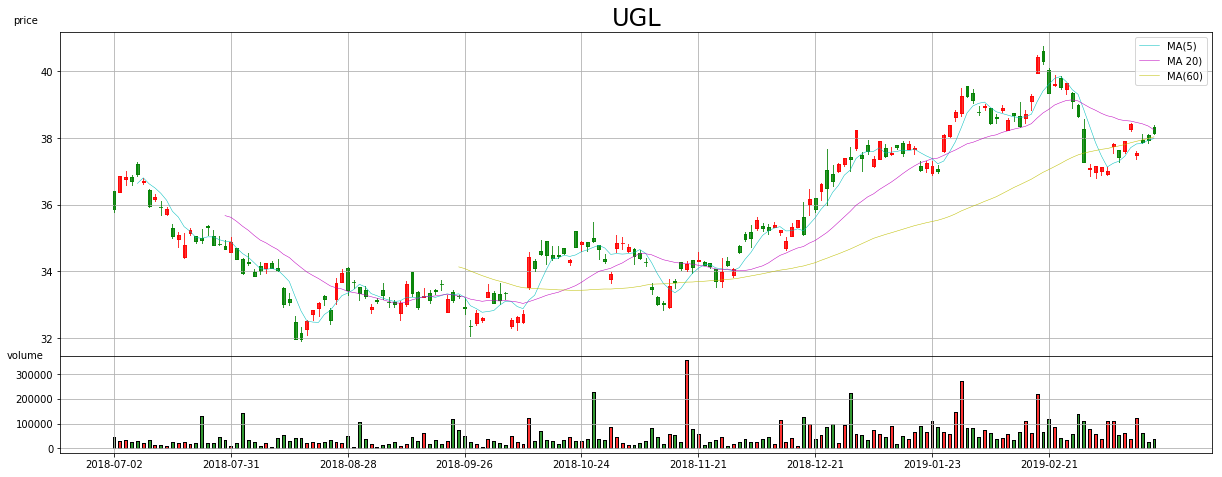

In [24]:
random_etf = np.random.choice(list(df_daily), 1)[0]
technical_analysis(random_etf, '2018-07-01')